Please enter the start date for the investment in the YYYY-MM-DD format:  2002-01-05


Sorry, the earliest record available is for 2002-03-01


Please enter the start date for the investment in the YYYY-MM-DD format:  eur


Provided date is not in correct format


Please enter the start date for the investment in the YYYY-MM-DD format:  usd


Provided date is not in correct format


Please enter the start date for the investment in the YYYY-MM-DD format:  gbp


Provided date is not in correct format


Please enter the start date for the investment in the YYYY-MM-DD format:  2002-03-01
Please enter the first currency (ISO format) for the investment:  eur
Please enter the second currency (ISO format) for the investment:  usd
Please enter the third currency (ISO format) for the investment:  gbp


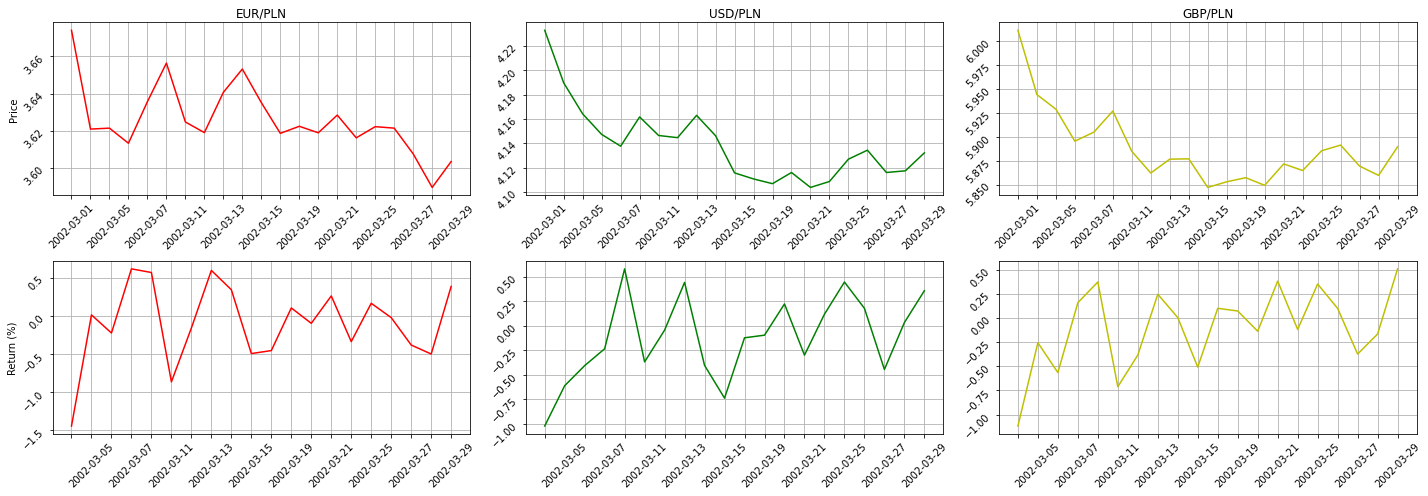

interactive(children=(FloatSlider(value=100.0, description='EUR (%)', layout=Layout(width='500px'), readout_fo…

In [4]:
#Import all necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import datetime
from datetime import timedelta
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import HTML

#Request the start date for the investment from the user
start_date = input('Please enter the start date for the investment in the YYYY-MM-DD format: ')
date_format = '%Y-%m-%d'     
    
     
while True:
#Check whether date is in correct format  
    if start_date < '2002-03-01':
        print('Sorry, the earliest record available is for 2002-03-01')
        start_date = input('Please enter the start date for the investment in the YYYY-MM-DD format: ')
    
#Check whether date is available in records  
    try:
        datetime.datetime.strptime(start_date, date_format)
        break
    except ValueError:
        print('Provided date is not in correct format')
        start_date = input('Please enter the start date for the investment in the YYYY-MM-DD format: ')
        

#Format date in order to add next 30 days for the investment period
year, month, day = map(int, start_date.split('-'))
next_date = datetime.date(year, month, day) + timedelta(30)
end_date = next_date.strftime('%Y') + '-' + next_date.strftime('%m') + '-' + next_date.strftime('%d')

#Request API data from the source database
nbp_import = requests.get('http://api.nbp.pl/api/exchangerates/tables/A/{stdate}/{endate}/'.format(stdate = str(start_date), endate = str(end_date)))
ccy_series = nbp_import.json()

table_frame = pd.DataFrame(ccy_series)  #Convert data into DataFrame format
uncut_rates = table_frame['rates']       #Get exchange rates
rates = [pd.DataFrame(line).set_index('code') for line in uncut_rates]  #Form a table by setting currency code as index

#Form the final DataFrame (currency matrix for investment) and get the available currency names
ccy_series = (pd.concat([rates[table]['mid'] for table in range(0, len(rates))], axis=1).transpose()).set_index(table_frame['effectiveDate'])
headers = [header for header in ccy_series]

#Request the currencies to be taken for the investment from the user and name potential errors
request_1 = 'Please enter the first currency (ISO format) for the investment: '
request_2 = 'Please enter the second currency (ISO format) for the investment: '
request_3 = 'Please enter the third currency (ISO format) for the investment: '

response_1 = 'Currency is not in ISO format'
response_2 = 'Unfortunately, we do not have such currency in our database'
response_3 = 'You have already selected this currency'

#Define the requests and include conditions to avoid errors
CCY_IN1 = str(input(request_1))
CCY_IN1 = CCY_IN1.upper()
while len(CCY_IN1) != 3:
    print(response_1)
    CCY_IN1 = str(input(request_1))
    CCY_IN1 = CCY_IN1.upper()
while CCY_IN1 not in headers:
    print(response_2)
    CCY_IN1 = str(input(request_1))
    CCY_IN1 = CCY_IN1.upper()
    
CCY_IN2 = str(input(request_2))
CCY_IN2 = CCY_IN2.upper()
while len(CCY_IN2) != 3:
    print(response_1)
    CCY_IN2 = str(input(request_2))
    CCY_IN2 = CCY_IN2.upper()
while CCY_IN2 == CCY_IN1:
    print(response_3)
    CCY_IN2 = str(input(request_2))
    CCY_IN2 = CCY_IN2.upper()
while CCY_IN2 not in headers:
    print(response_2)
    CCY_IN2 = str(input(request_2))
    CCY_IN2 = CCY_IN2.upper()
CCY_IN3 = str(input(request_3))
CCY_IN3 = CCY_IN3.upper()

while len(CCY_IN3) != 3:
    print(response_1)
    CCY_IN3 = str(input(request_3))
    CCY_IN3 = CCY_IN3.upper()
while CCY_IN3 in [CCY_IN1, CCY_IN2]:
    print(response_3)
    CCY_IN3 = str(input(request_3))
    CCY_IN3 = CCY_IN3.upper()
while CCY_IN3 not in headers:
    print(response_2)
    CCY_IN3 = str(input(request_3))
    CCY_IN3 = CCY_IN3.upper()

ccy = [CCY_IN1, CCY_IN2, CCY_IN3]     #Get the codes of chosen currencies

##Create series for each currency which will be later used for the analysis

#Price series
ccy1_series = ccy_series[CCY_IN1]
ccy2_series = ccy_series[CCY_IN2]
ccy3_series = ccy_series[CCY_IN3]

#Daily returns series
ccy1_daily = pd.DataFrame((ccy1_series).pct_change(1))
ccy2_daily = pd.DataFrame((ccy2_series).pct_change(1))
ccy3_daily = pd.DataFrame((ccy3_series).pct_change(1))

#Log-returns series
ccy1_logdaily = np.log(pd.DataFrame(ccy1_series)) - np.log(pd.DataFrame(ccy1_series).shift(1))
ccy2_logdaily = np.log(pd.DataFrame(ccy2_series)) - np.log(pd.DataFrame(ccy2_series).shift(1))
ccy3_logdaily = np.log(pd.DataFrame(ccy3_series)) - np.log(pd.DataFrame(ccy3_series).shift(1))


##MATPLOTLIB SUBPLOTS AND IPYWIDGETS FOR THE FINAL OUTPUT
#Define plots for suplots
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20,7))

#Choose the kind of plots and their attributes
ax1.plot(ccy1_series, color='r')
ax2.plot(ccy2_series, color='g')
ax3.plot(ccy3_series, color='y')
ax4.plot(ccy1_daily*100, color='r') #Serie * 100 in order to express as percentage
ax5.plot(ccy2_daily*100, color='g')
ax6.plot(ccy3_daily*100, color='y')

#Choose further parameters (tick rotations, hide every 2nd tick, plot titles, show grid)
ax1.tick_params(labelrotation=45)
ax1.set_title(CCY_IN1+'/PLN')
ax1.grid()
[l.set_visible(False) for (i, l) in enumerate(ax1.xaxis.get_ticklabels()) if i % 2 !=0]
ax1.set_ylabel('Price', rotation=90, fontsize=10)

ax2.tick_params(labelrotation=45)
ax2.set_title(CCY_IN2+'/PLN')
ax2.grid()
[l.set_visible(False) for (i, l) in enumerate(ax2.xaxis.get_ticklabels()) if i % 2 !=0]

ax3.tick_params(labelrotation=45)
ax3.set_title(CCY_IN3+'/PLN')
ax3.grid()
[l.set_visible(False) for (i, l) in enumerate(ax3.xaxis.get_ticklabels()) if i % 2 !=0]

ax4.tick_params(labelrotation=45)
ax4.grid()
[l.set_visible(False) for (i, l) in enumerate(ax4.xaxis.get_ticklabels()) if i % 2 !=0]
ax4.set_ylabel('Return (%)', rotation=90, fontsize=10)

ax5.tick_params(labelrotation=45)
ax5.grid()
[l.set_visible(False) for (i, l) in enumerate(ax5.xaxis.get_ticklabels()) if i % 2 !=0]

ax6.tick_params(labelrotation=45)
ax6.grid()
[l.set_visible(False) for (i, l) in enumerate(ax6.xaxis.get_ticklabels()) if i % 2 !=0]

#Adjust padding between plots and display them
plt.tight_layout()
plt.show()

#Define the sliders using IpyWidgets
amp1 = widgets.FloatSlider(min=0, max=100, step=0.5, value=100, description=str(CCY_IN1 + ' (%)'),
                           readout_format ='.1f', layout=widgets.Layout(width='500px'))
amp2 = widgets.FloatSlider(min=0, max=100, step=0.5, value=0, description=str(CCY_IN2 + ' (%)'), 
                           readout_format ='.1f', layout=widgets.Layout(width='500px'))
amp3 = widgets.FloatSlider(min=0, max=100, step=0.5, value=0, description=str(CCY_IN3 + ' (%)'), 
                           readout_format ='.1f', layout=widgets.Layout(width='500px'))

#Create functions for sliders to interact between each other (all three sliders should sum to 100)
def update_slider1(change):
    amp2.value = 100 - amp1.value - amp3.value
    amp3.value = 100 - amp2.value - amp1.value
def update_slider2(change):
    amp3.value = 100 - amp2.value - amp1.value
    amp1.value = 100 - amp3.value - amp2.value
def update_slider3(change):
    amp1.value = 100 - amp3.value - amp2.value
    amp2.value = 100 - amp1.value - amp3.value
    
amp1.observe(update_slider1, 'value')
amp2.observe(update_slider2, 'value')
amp3.observe(update_slider3, 'value')

#Define the function which allows IpyWidgets to constantly update the plot and the HTML texts below it
#Consecutively, total portfolio return serie (in PLN), total portfolio log-return, the currency giving highest returns
def portfolio_plotter(A, B, C):
    fig, ax_plot = plt.subplots(figsize=(25,7))
    port_daily = pd.concat([ccy1_daily*1000*amp1.value/100, ccy2_daily*1000*amp2.value/100, ccy3_daily*1000*amp3.value/100],
                               axis=1, join='inner').sum(axis=1).dropna()
    port_logdaily = pd.concat([ccy1_logdaily*amp1.value/100, ccy2_logdaily*amp2.value/100, ccy3_logdaily*amp3.value/100],
                               axis=1, join='inner').sum(axis=1).dropna()
    condition = np.array2string(np.where(max(float(ccy1_daily.sum()), float(ccy2_daily.sum()), float(ccy3_daily.sum()))==float(ccy1_daily.sum()), CCY_IN1, np.where(
        max(float(ccy1_daily.sum()), float(ccy2_daily.sum()), float(ccy3_daily.sum()))==float(ccy2_daily.sum()), CCY_IN2, CCY_IN3)))
    result = pd.DataFrame([ccy1_daily.add(1).prod().sub(1)*1000*amp1.value/100, 
                           ccy2_daily.add(1).prod().sub(1)*1000*amp2.value/100, 
                           ccy3_daily.add(1).prod().sub(1)*1000*amp3.value/100]).sum().sum().round(2)
    
    ax_plot.plot(port_daily)
    [l.set_visible(False) for (i, l) in enumerate(ax_plot.xaxis.get_ticklabels()) if i % 2 !=0]
    plt.ylabel('Total return (in PLN)', size=13)
    plt.grid()
    plt.show()
    print('')
    display(HTML('The investment made <b>PLN {res}</b> {pl}.'.format(
        res=result, 
        pl=(np.where(result<0, 'loss', 'profit')))))
    
    display(HTML('Mean return for the portfolio is <b>PLN {mean}</b>. The daily volatility during investment period was <b>{vol} %</b>.'.format(
        mean=port_daily.mean().round(4), 
        vol=(port_logdaily.std()*np.sqrt(len(port_logdaily)*100)).round(3))))
    
    display(HTML('The best day for the portfolio was <b>{day1}</b>, while the worst was <b>{day2}</b>'.format(
        day1=port_daily.idxmax(),
        day2=port_daily.idxmin())))
    
    display(HTML('The best performing currency was <b>{}</b>'.format(condition)))

#Display the final output
iplot = widgets.interactive(portfolio_plotter, A = amp1, B = amp2, C = amp3 )
display(iplot)


